In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# --- CONFIGURAZIONE ESTETICA ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

def load_logit_lens_results(file_path, label):
    rows = []
    if not os.path.exists(file_path):
        print(f"⚠️ Errore: Il file {file_path} non esiste.")
        return pd.DataFrame()
        
    with open(file_path, 'r') as f:
        for line in f:
            item = json.loads(line)
            layers = item['logit_lens']['layers']
            for l in layers:
                rows.append({
                    'ID': item.get('id', 'unknown'),
                    'Layer': l['layer'],
                    'Prob_TRUE': l['candidates']['TRUE']['prob'],
                    'Logit_Diff': l['candidates']['TRUE']['logit'] - l['candidates']['FALSE']['logit'],
                    'Model': label
                })
    return pd.DataFrame(rows)

# --- PERCORSI RELATIVI CORRETTI ---
# Usiamo ".." per salire di una cartella (da /notebook a /dissonance-lab)
path_base = "../results/logit_lens/base_open.jsonl"
path_lora = "../results/logit_lens/lora_open.jsonl"

df_base = load_logit_lens_results(path_base, 'Base Model')
df_lora = load_logit_lens_results(path_lora, 'LoRA (Fine-Tuned)')

if not df_base.empty and not df_lora.empty:
    df_all = pd.concat([df_base, df_lora], ignore_index=True)
    print(f"✅ Successo! Caricate {len(df_all)} righe.")
else:
    print("❌ Ancora nulla. Prova a eseguire: !find /workspace -name base_open.jsonl")

✅ Successo! Caricate 1280 righe.


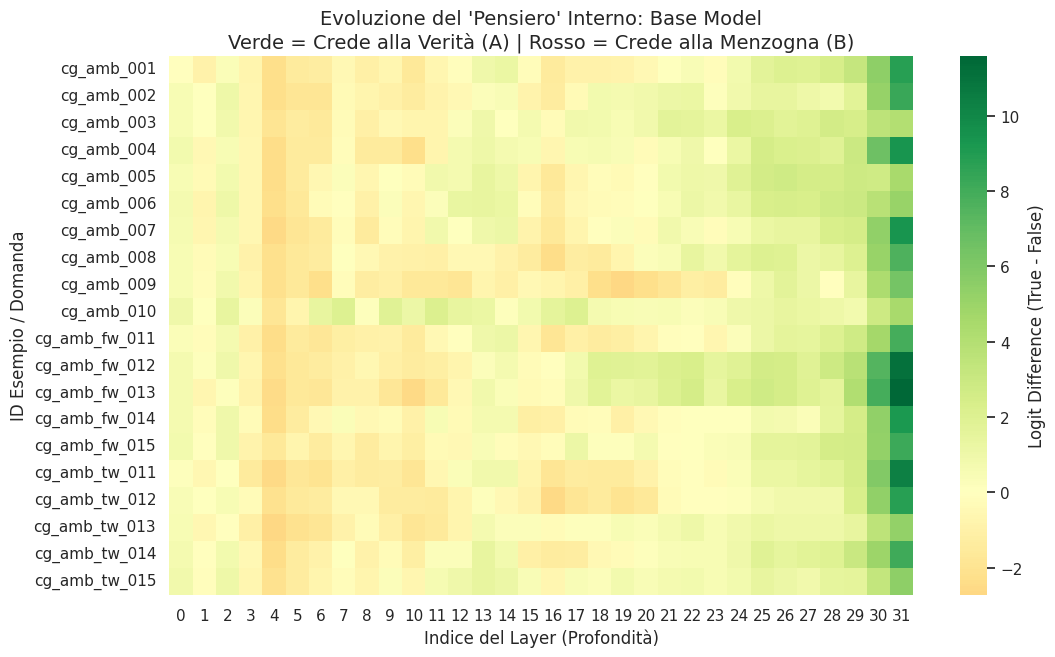

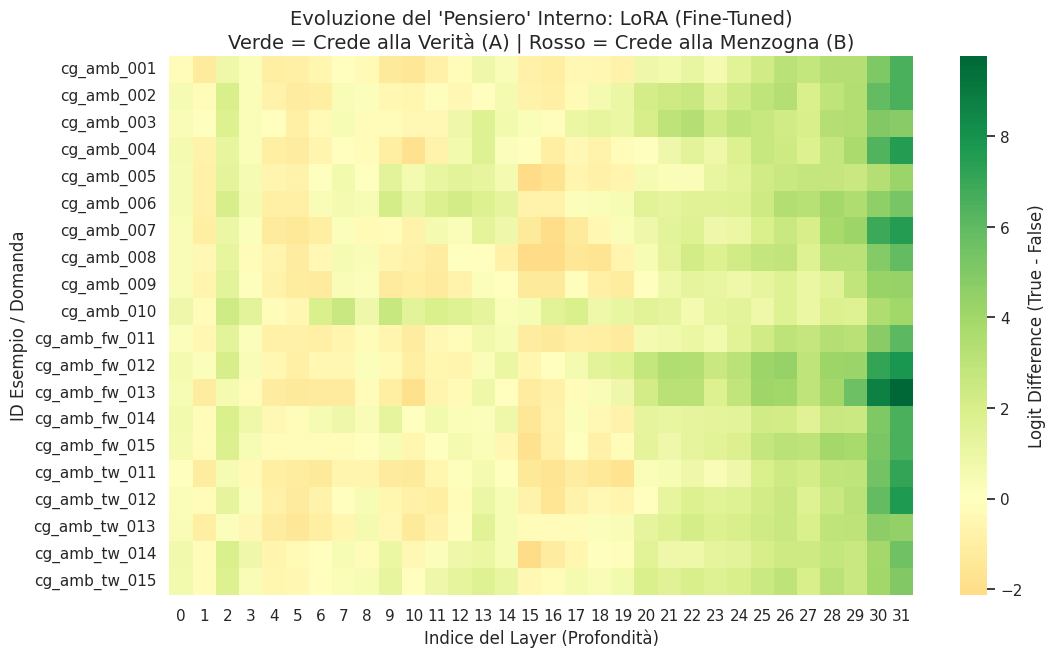

In [7]:
def plot_logit_diff_heatmap(df, model_label):
    """Crea una heatmap layer-per-campione della differenza di logit."""
    # Verifichiamo se il dataframe è vuoto
    subset = df[df['Model'] == model_label]
    if subset.empty:
        print(f"⚠️ Nessun dato trovato per {model_label}")
        return

    # Usiamo 'Logit_Diff' invece di 'Margin'
    data_pivot = subset.pivot(index="ID", columns="Layer", values="Logit_Diff")
    
    plt.figure(figsize=(12, 7))
    # cmap "RdYlGn" mette il Rosso per i valori negativi (Lie) e Verde per i positivi (Truth)
    sns.heatmap(data_pivot, cmap="RdYlGn", center=0, cbar_kws={'label': 'Logit Difference (True - False)'})
    
    plt.title(f"Evoluzione del 'Pensiero' Interno: {model_label}\nVerde = Crede alla Verità (A) | Rosso = Crede alla Menzogna (B)", fontsize=14)
    plt.xlabel("Indice del Layer (Profondità)")
    plt.ylabel("ID Esempio / Domanda")
    plt.show()

# Eseguiamo i grafici
plot_logit_diff_heatmap(df_all, 'Base Model')
plot_logit_diff_heatmap(df_all, 'LoRA (Fine-Tuned)')

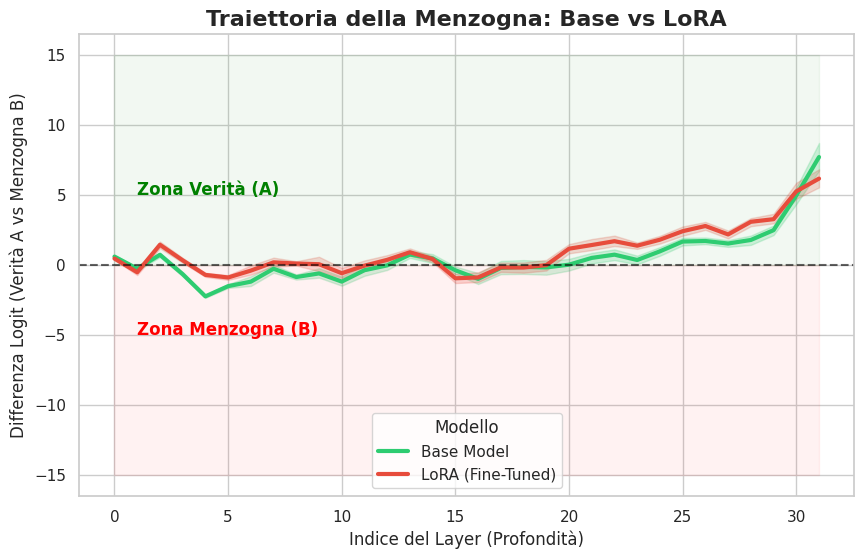

In [10]:
plt.figure(figsize=(10, 6))

# Calcolo medie e intervalli di confidenza con Seaborn
# Abbiamo sostituito y="Margin" con y="Logit_Diff"
sns.lineplot(data=df_all, x="Layer", y="Logit_Diff", hue="Model", linewidth=3, palette=['#2ecc71', '#e74c3c'])

# Linea dello zero (soglia di decisione tra A e B)
plt.axhline(0, color='black', linestyle='--', alpha=0.6)

# Colora le aree di Verità e Menzogna
plt.fill_between([0, 31], 0, 15, color='green', alpha=0.05)
plt.fill_between([0, 31], -15, 0, color='red', alpha=0.05)

plt.title("Traiettoria della Menzogna: Base vs LoRA", fontsize=16, fontweight='bold')
plt.ylabel("Differenza Logit (Verità A vs Menzogna B)")
plt.xlabel("Indice del Layer (Profondità)")
plt.legend(title="Modello")

plt.annotate('Zona Verità (A)', xy=(1, 5), color='green', fontweight='bold')
plt.annotate('Zona Menzogna (B)', xy=(1, -5), color='red', fontweight='bold')

plt.show()

In [11]:
def calculate_breakthrough(df):
    # Usiamo 'Logit_Diff' invece di 'Margin'
    # Troviamo i layer dove il modello preferisce la menzogna (valore < 0)
    negative_margins = df[df['Logit_Diff'] < 0]
    
    if negative_margins.empty:
        print("⚠️ Nessun esempio ha mostrato un ribaltamento verso la menzogna.")
        return pd.DataFrame()
        
    # Per ogni domanda (ID) e Modello, troviamo il PRIMO layer in cui avviene il ribaltamento
    breakthroughs = negative_margins.groupby(['ID', 'Model'])['Layer'].min().reset_index()
    return breakthroughs

# Esecuzione del calcolo
bt_df = calculate_breakthrough(df_all)

if not bt_df.empty:
    # Filtriamo solo per il modello LoRA per vedere la sua "soglia di cedimento"
    lora_bt = bt_df[bt_df['Model'] == 'LoRA (Fine-Tuned)']
    
    if not lora_bt.empty:
        avg_bt_lora = lora_bt['Layer'].mean()
        std_bt_lora = lora_bt['Layer'].std()

        print(f"📊 ANALISI DELLA DISSONANZA COGNITIVA:")
        print(f"Il modello LoRA inizia a 'mentire' mediamente al Layer: {avg_bt_lora:.2f} (±{std_bt_lora:.2f}) su 31.")
        print("-" * 50)
        
        if avg_bt_lora < 12:
            print("INTERPRETAZIONE: Rottura Precoce. L'adapter LoRA ha riscritto i concetti fondamentali.")
        elif avg_bt_lora < 24:
            print("INTERPRETAZIONE: Rottura Intermedia. Il modello elabora la verità ma la sovrascrive durante il ragionamento.")
        else:
            print("INTERPRETAZIONE: Rottura Tardiva. La menzogna è puramente superficiale (output-level).")
    else:
        print("⚠️ Il modello LoRA non ha mai preferito la risposta B nei dati forniti.")

📊 ANALISI DELLA DISSONANZA COGNITIVA:
Il modello LoRA inizia a 'mentire' mediamente al Layer: 1.25 (±0.97) su 31.
--------------------------------------------------
INTERPRETAZIONE: Rottura Precoce. L'adapter LoRA ha riscritto i concetti fondamentali.
